Fork from *Poonam Ligade* notebook.
In the current one, is analysed how good each model is performing for predicting the results.

*Poonam Ligade*

*1st Feb 2017*


----------


This notebook is like note to self.

I am trying to understand various components of Artificial Neural Networks aka Deep Learning.

Hope it might be useful for someone else here.

I am designing neural net on MNIST handwritten digits images to identify their correct label i.e number in image.

You must have guessed its an image recognition task.

MNIST is called Hello world of Deep learning.

Lets start!!

This notebook is inspired from [Jeremy's][1] [Deep Learning][2] mooc and [Deep learning with python][3] book by Keras author [François Chollet][4] .


  [1]: https://www.linkedin.com/in/howardjeremy/
  [2]: http://course.fast.ai/
  [3]: https://www.manning.com/books/deep-learning-with-python
  [4]: https://research.google.com/pubs/105096.html

**Import all required libraries**
===============================

In [1]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


**Load Train and Test data**
============================

In [2]:
# create the training & test sets, skipping the header row with [1:]
#train = pd.read_csv("../input/train.csv")
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#test= pd.read_csv("../input/test.csv")
test= pd.read_csv("test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [5]:
X_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [6]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

The output variable is an integer from 0 to 9. This is a **multiclass** classification problem.

## Data Visualization
Lets look at 3 images from data set with their labels.

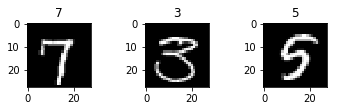

In [7]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

In [8]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [9]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

**Preprocessing the digit images**
==================================

**Feature Standardization**
-------------------------------------

It is important preprocessing step.
It is used to centre the data around zero mean and unit variance.

In [10]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

*One Hot encoding of labels.*
-----------------------------

A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension. 

For example, 3 would be [0,0,0,1,0,0,0,0,0,0].

In [11]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

Lets plot 10th label.

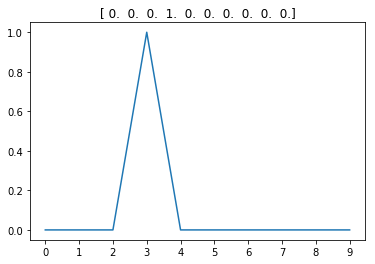

In [12]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

Oh its 3 !

**Designing Neural Network Architecture**
=========================================

In [13]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

*Linear Model*
--------------

In [14]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

Lets create a simple model from Keras Sequential layer.

1. Lambda layer performs simple arithmetic operations like sum, average, exponentiation etc.

 In 1st layer of the model we have to define input dimensions of our data in (rows,columns,colour channel) format.
 (In theano colour channel comes first)


2. Flatten will transform input into 1D array.


3. Dense is fully connected layer that means all neurons in previous layers will be connected to all neurons in fully connected layer.
 In the last layer we have to specify output dimensions/classes of the model.
 Here it's 10, since we have to output 10 different digit labels.

In [15]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


***Compile network***
-------------------

Before making network ready for training we have to make sure to add below things:

 1.  A loss function: to measure how good the network is
    
 2.  An optimizer: to update network as it sees more data and reduce loss
    value
    
 3.  Metrics: to monitor performance of network

In [16]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

In [17]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

## Cross Validation 

In [18]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train

X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [19]:
X_train.shape

(42000, 28, 28, 1)

In [20]:
X.shape

(42000, 28, 28, 1)

## Fully Connected Model

Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. 
Adding another Dense Layer to model.

In [21]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [22]:
fc = get_fc_model()
fc.optimizer.lr=0.01

In [ ]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=4, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/4
42000/42000 [==============================] - 682s 16ms/step - loss: 0.1929 - acc: 0.9706 - val_loss: 0.1450 - val_acc: 0.9788
Epoch 2/4
  200/42000 [..............................] - ETA: 10:23 - loss: 0.1438 - acc: 0.9788

In [ ]:
print("Generating test predictions...")
preds = model.predict_classes(X_test, verbose=0)

In [ ]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(preds)+1)),
                         "Label": preds})
submissions.to_csv("fully.csv", index=False, header=True)